In [249]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
#from analytics_tools.analytics_tools3 import freq_discrete
%matplotlib inline

In [250]:
def metricas(model,Xt,Xv,yt,yv):
    print "Accuracy_Train %.2f, Accuracy_Validate %.2f "%(accuracy_score(y_pred=model.predict(Xt),y_true=yt),accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print "ROC_Train %.2f, ROC_Validate %.2f "%(roc_auc_score(y_score=model.predict_proba(Xt)[:,1],y_true=yt),roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))


In [251]:
df = pd.read_excel('Data/churn.xlsx')

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801 entries, 0 to 2800
Data columns (total 14 columns):
V_ACCT_LGHT      2801 non-null int64
C_IP             2801 non-null object
C_VMP            2801 non-null object
V_N_VM_MESS      2801 non-null int64
V_T_DAY_CHG      2801 non-null float64
V_T_EVE_CALLS    2801 non-null int64
V_T_EVE_CHG      2801 non-null float64
V_T_NIG_CALLS    2801 non-null int64
V_T_NIG_CHG      2801 non-null float64
V_T_INT_CALLS    2801 non-null int64
V_T_INT_CHG      2801 non-null float64
V_CS_CALLS       2801 non-null int64
TARGET           2801 non-null int64
ID               2801 non-null int64
dtypes: float64(4), int64(8), object(2)
memory usage: 306.4+ KB


In [253]:
df.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128,No,Yes,25,45.07,99,16.78,91,11.01,3,2.70,1,0,1
1,107,No,Yes,26,27.47,103,16.62,103,11.45,3,3.70,1,0,2
2,137,No,No,0,41.38,110,10.30,104,7.32,5,3.29,0,0,3
3,65,No,No,0,21.95,83,19.42,111,9.40,6,3.43,4,1,11
4,168,No,No,0,21.90,71,8.92,128,6.35,2,3.02,1,0,13


In [254]:
var_cont = [v for v in df.columns if v[:2]=='V_']
var_disc = [v for v in df.columns if v[:2]=='C_']

In [255]:
len(var_cont),len(var_disc)

(10, 2)

In [256]:
df['C_IP'] = np.where(df['C_IP']=='Yes',-1.43065547791029,0.258835578050761)
df['C_VMP'] = np.where(df['C_VMP'] == 'Yes',0.510385966691421,-0.14832901744704)



In [257]:
for v in var_cont:
    print v
    df[v]= pd.cut(df[v],bins=5).astype(str)
    aux = df[[v,'TARGET']].copy()
    aux['n'] = 1
    aux = aux.pivot_table(aggfunc='count',
                          columns='TARGET',
                          fill_value=0,
                          index=v,
                          values='n')
    aux.reset_index(inplace=True)
    for i in range(2):
        aux[i]/=aux[i].sum()

    aux['woe'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    df = df.merge(aux,on=v,how='inner')
    df.drop(v,axis=1,inplace=True)
    df.rename(columns={'woe':v},inplace=True)

V_ACCT_LGHT
V_N_VM_MESS
V_T_DAY_CHG
V_T_EVE_CALLS
V_T_EVE_CHG
V_T_NIG_CALLS
V_T_NIG_CHG
V_T_INT_CALLS
V_T_INT_CHG
V_CS_CALLS


In [258]:
df.head()

,C_IP,C_VMP,TARGET,ID,V_ACCT_LGHT,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS
0,0.258836,0.510386,0,1,0.061033,1.219037,-1.864202,0.068283,0.065696,-0.089148,-0.05179,-0.29035,0.007263,0.295956
1,0.258836,-0.148329,0,2170,0.061033,-0.147174,0.561314,-0.053201,0.065696,-0.089148,-0.05179,-0.29035,0.007263,0.295956
2,0.258836,-0.148329,0,3022,0.053118,-0.147174,0.178109,-0.053201,0.065696,-0.089148,-0.05179,-0.29035,0.007263,0.295956
3,0.258836,0.510386,0,558,0.053118,1.219037,0.561314,0.031576,0.065696,-0.089148,-0.05179,-0.29035,0.007263,0.295956
4,0.258836,-0.148329,0,3117,0.061033,-0.147174,0.561314,0.031576,0.065696,-0.089148,-0.05179,-0.29035,0.007263,0.295956


In [259]:
X = df[var_disc+var_cont]
y = df['TARGET']

In [260]:
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [261]:
model = LogisticRegression()

In [262]:
model.fit(Xt,yt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [263]:
metricas(model,Xt,Xv,yt,yv)

Accuracy_Train 0.88, Accuracy_Validate 0.90 
ROC_Train 0.87, ROC_Validate 0.86 


(array([2000.,  253.,  104.,  112.,  104.,   83.,   52.,   35.,   30.,
          28.]),
 array([0.00212489, 0.10080192, 0.19947895, 0.29815598, 0.39683301,
        0.49551004, 0.59418707, 0.69286409, 0.79154112, 0.89021815,
        0.98889518]),
 <a list of 10 Patch objects>)

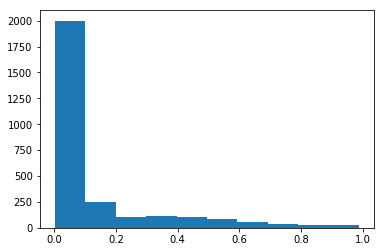

In [264]:
plt.hist(model.predict_proba(X)[:,1])